In [15]:
import torch
import torch.nn as nn
from torch import optim

from hednet import HedNet
from eval_hed import eval_net
from torch.utils.data import DataLoader, random_split
from utils.dataset import BasicDataset
from tqdm import tqdm


epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
val_percent = 0.2
img_scale = 1
dir_img = 'data/fibergen/images/'
dir_mask = 'data/fibergen/masks/'
batch_size = 5
lr = 0.001

dataset = BasicDataset(dir_img, dir_mask, img_scale)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

In [16]:
net = HedNet(n_channels=3, n_classes=1, bilinear=False)
net.to(device=device)

#print(f'len={len(val_loader)}')
criterion = nn.MSELoss()

#optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr)

for epoch in range(epochs):
    net.train()
    
    epoch_loss = 0
    with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            imgs, true_masks = batch['image'], batch['mask']
            
            imgs = imgs.to(device=device, dtype=torch.float32)
            true_masks = true_masks.to(device=device, dtype=torch.float32)
            
            masks_pred = net(imgs)[0]
            
            loss = criterion(masks_pred, true_masks)
            epoch_loss += loss.item()
            
            pbar.set_postfix(**{'loss (batch)': loss.item()})
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            pbar.update(imgs.shape[0])
    
    print(f'Epoch Loss: {epoch_loss}')
    # validation    
    val_score = eval_net(net, val_loader, device, side=0)
    print(f'Validation MSE: {val_score}')

Validation round:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch Loss: 0.7909219804278109


Epoch 2/10:   0%|          | 0/400 [00:00<?, ?img/s]                

Validation MSE: 0.00017842442612163721


Validation round:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch Loss: 0.011232492041017395


Epoch 3/10:   0%|          | 0/400 [00:00<?, ?img/s]                

Validation MSE: 0.00011919242169824428


Validation round:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch Loss: 0.008861886912200134


Epoch 4/10:   0%|          | 0/400 [00:00<?, ?img/s]                

Validation MSE: 0.00010290467544109561


Validation round:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch Loss: 0.008386423040064983


Epoch 5/10:   0%|          | 0/400 [00:00<?, ?img/s]                

Validation MSE: 9.998509813158307e-05


Validation round:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch Loss: 0.008114114607451484


Epoch 6/10:   0%|          | 0/400 [00:00<?, ?img/s]                

Validation MSE: 9.793095923669171e-05


Validation round:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch Loss: 0.007950507904752158


Epoch 7/10:   0%|          | 0/400 [00:00<?, ?img/s]                

Validation MSE: 9.675132714619395e-05


Validation round:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch Loss: 0.007873466704040766


Epoch 8/10:   0%|          | 0/400 [00:00<?, ?img/s]                

Validation MSE: 9.506644455541391e-05


Validation round:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch Loss: 0.007823376916348934


Epoch 9/10:   0%|          | 0/400 [00:00<?, ?img/s]                

Validation MSE: 9.423018345842138e-05


Validation round:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch Loss: 0.007774413752485998


Epoch 10/10:   0%|          | 0/400 [00:00<?, ?img/s]               

Validation MSE: 9.373351931571961e-05


Validation round:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch Loss: 0.007765653033857234


Validation MSE: 9.336871080449783e-05


In [17]:
torch.save(net.state_dict(), 'MODEL.pth')
print(f'modelo guardado')

modelo guardado


output.shape = torch.Size([1, 1, 256, 256])
output.shape = torch.Size([1, 256, 256])


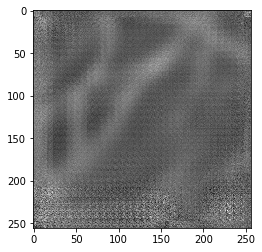

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

net.eval()

full_img = Image.open('data/fibergen/test/0001.png')
img = torch.from_numpy(BasicDataset.preprocess(full_img, 1))
img = img.unsqueeze(0)
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad():
    output = net(img)[0]

print(f'output.shape = {output.shape}')

output = output.squeeze(0)

print(f'output.shape = {output.shape}')

#print(f'full_img.size[1] = {full_img.size[0]}')

tf = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize(full_img.size[1]),
        transforms.ToTensor()
    ]
)


mask = output.squeeze().cpu().numpy()

plt.imshow(mask, cmap='gray')
plt.show()


In [8]:
import torch
import torch.nn.functional as F

input = torch.randn(2, 1)

output = torch.randn(2, 1)

print(f'input = {input}')
print(f'output = {output}')




input = tensor([[-0.1224],
        [ 2.3980]])
output = tensor([[ 3.1675],
        [-0.0142]])


In [15]:
mse = F.mse_loss(output, input, reduction='mean').item()

In [16]:
print(f'mse = {mse}')

mse = 8.321056365966797


### 